In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [2]:
# Загрузка данных
data = pd.read_csv("SBER_240101_240430.csv", delimiter=";")
data.drop(columns=['<PER>', '<TIME>', '<TICKER>', '<DATE>'], inplace=True)

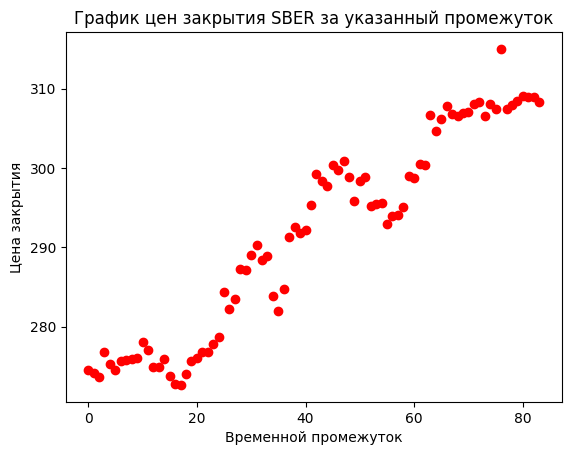

In [3]:
# График цен закрытия
plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro')
plt.xlabel("Временной промежуток")
plt.ylabel("Цена закрытия")
plt.title("График цен закрытия SBER за указанный промежуток")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                <CLOSE>   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     990.8
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.50e-47
Time:                        15:49:54   Log-Likelihood:                -224.50
No. Observations:                  84   AIC:                             453.0
Df Residuals:                      82   BIC:                             457.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        270.7838      0.767    353.097      0.0

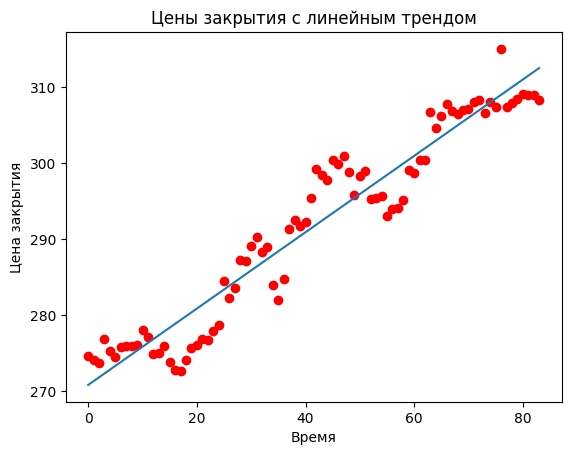

In [4]:

# Линейная регрессия
time = np.array([i for i in range(len(data))])
X = np.array([i for i in range(len(data))]).reshape(-1, 1)
y = data['<CLOSE>']

# Модель линейной регрессии
X_with_const = sm.add_constant(X)
sm_model = sm.OLS(y, X_with_const).fit()
print(sm_model.summary())

# Построение тренда
model_params = np.array(sm_model.params)
plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro',
         [i for i in range(len(data))], [(i * model_params[1] + model_params[0]) for i in range(len(data))])
plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Цены закрытия с линейным трендом")
plt.show()


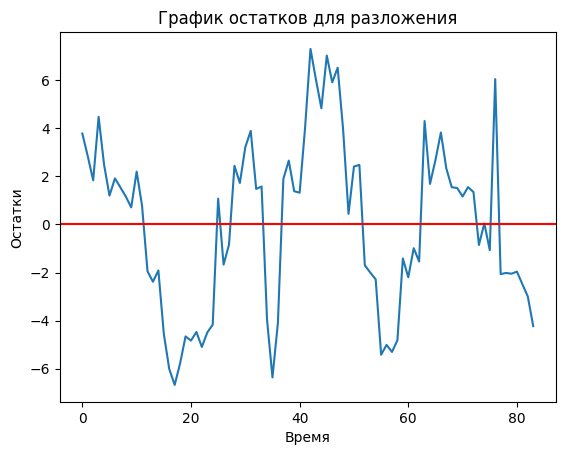

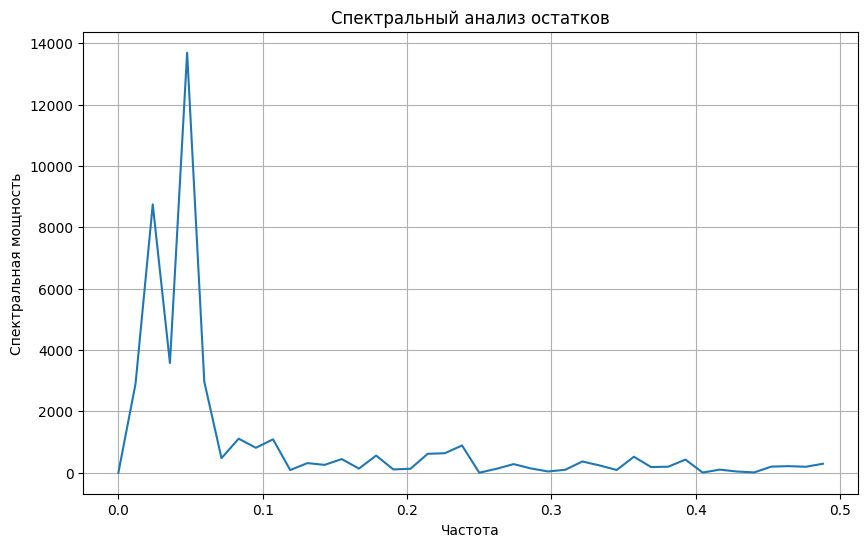

In [5]:
# Остатки
residuals = y.to_numpy() - [(i * model_params[1] + model_params[0]) for i in range(len(data))]
plt.plot(time, residuals)
plt.axhline(0, color='red')
plt.xlabel("Время")
plt.ylabel("Остатки")
plt.title("График остатков для разложения")
plt.show()

# Дискретное преобразование Фурье для остатков
N = len(residuals)
frequencies = fftfreq(N)  # Частоты
amplitudes = fft(residuals)  # Преобразование
power = np.abs(amplitudes)**2  # Спектральная мощность

# Отображаем положительные частоты
positive_frequencies = frequencies[:N // 2]
positive_power = power[:N // 2]

# Построение спектра
plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, positive_power)
plt.title("Спектральный анализ остатков")
plt.xlabel("Частота")
plt.ylabel("Спектральная мощность")
plt.grid()
plt.show()


In [6]:
fourier_params = {}
freq_params = []

In [7]:
# Создаем копии массивов, чтобы не изменять оригинальные данные
remaining_power = positive_power.copy()
remaining_frequencies = positive_frequencies.copy()

In [8]:
# Цикл для добавления синусоидальных компонент в модель
for step in range(1, 40): 
# Находим индекс частоты с максимальной амплитудой
    top_index = np.argmax(remaining_power)
    max_frequency = remaining_frequencies[top_index]
    freq_params.append(max_frequency)

    # Удаляем использованную частоту и её амплитуду из рассмотрения
    remaining_power = np.delete(remaining_power, top_index)
    remaining_frequencies = np.delete(remaining_frequencies, top_index)

    # Формируем компоненты для текущей частоты
    cos_component = np.cos(2 * np.pi * max_frequency * time).reshape(-1, 1)
    sin_component = np.sin(2 * np.pi * max_frequency * time).reshape(-1, 1)
    X_forstep = np.hstack((cos_component,sin_component))
   
    model_cosandsin = sm.OLS(residuals,X_forstep).fit()
    print(f"Результаты модели для ряда фурье при шаге {step} и частоте {max_frequency}:")
    print(model_cosandsin.summary())

    # Проверка значимости для косинуса
    if model_cosandsin.pvalues[0] < 0.05 and model_cosandsin.pvalues[1] <0.05 and model_cosandsin.f_pvalue <0.05: 
        print(f"\nКоэф при косинусе и синусе {model_cosandsin.params}  значимы, значимость модели - {model_cosandsin.f_pvalue}")
        fourier_params.update({f"Sin{step} & Cos{step}" :model_cosandsin.params})
        residuals -= model_cosandsin.fittedvalues
    elif model_cosandsin.pvalues[0] >= 0.05 and model_cosandsin.pvalues[1] < 0.05 and model_cosandsin.f_pvalue <0.05:
        model_cosandsin = sm.OLS(residuals,sin_component).fit()
        print(model_cosandsin.summary())
        residuals -= model_cosandsin.fittedvalues
        fourier_params.update({f"Sin{step}" :model_cosandsin.params})
        print(f"\nКоэф при косинусе не значим, при синусе - значим {model_cosandsin.params}, значимость модели - {model_cosandsin.f_pvalue}")
    elif model_cosandsin.pvalues[0] < 0.05 and model_cosandsin.pvalues[1] >= 0.05 and model_cosandsin.f_pvalue <0.05:
        model_cosandsin = sm.OLS(residuals,cos_component).fit()
        fourier_params.update({f"Cos{step}" :model_cosandsin.params})
        print(f"\nКоэф при косинусе {model_cosandsin.params} значим, при синусе - незначим, значимость модели - {model_cosandsin.f_pvalue}")
        residuals -= model_cosandsin.fittedvalues
    elif model_cosandsin.pvalues[0] >= 0.05 and model_cosandsin.pvalues[1] >= 0.05 and model_cosandsin.f_pvalue < 0.05:
        print(f"Оба коэффициента на шаге {step} оказались не значимыми")
        continue
    else:
        print(f"Модель перестала быть значимой на шаге {step}")
        print(model_cosandsin.summary())
        break

Результаты модели для ряда фурье при шаге 1 и частоте 0.047619047619047616:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.316
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              18.95
Date:                Sun, 29 Dec 2024   Prob (F-statistic):                    1.71e-07
Time:                        15:49:54   Log-Likelihood:                         -208.54
No. Observations:                  84   AIC:                                      421.1
Df Residuals:                      82   BIC:                                      425.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t 

In [9]:
fourier_params

{'Sin1': array([2.77700866]),
 'Cos2': array([2.18138619]),
 'Sin3 & Cos3': array([-1.07808404,  0.92967821]),
 'Sin4': array([-1.20161803]),
 'Sin5 & Cos5': array([-0.74963429, -1.04135926]),
 'Sin6': array([0.6433004]),
 'Sin7': array([0.75750445]),
 'Cos8': array([0.70865243]),
 'Cos9': array([0.67415576]),
 'Sin10': array([0.48002254]),
 'Cos11': array([0.47001157])}

In [10]:
freq_params

[0.047619047619047616,
 0.023809523809523808,
 0.03571428571428571,
 0.05952380952380952,
 0.011904761904761904,
 0.08333333333333333,
 0.10714285714285714,
 0.23809523809523808,
 0.09523809523809523,
 0.22619047619047616,
 0.21428571428571427,
 0.17857142857142855]

In [37]:
len(freq_params)

12

In [11]:
#Итоговая модель:

In [12]:
cos_component = np.cos(2 * np.pi * max_frequency * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_frequency * time).reshape(-1, 1)

In [13]:
model_params

array([270.78376471,   0.50223286])

In [14]:
features= []

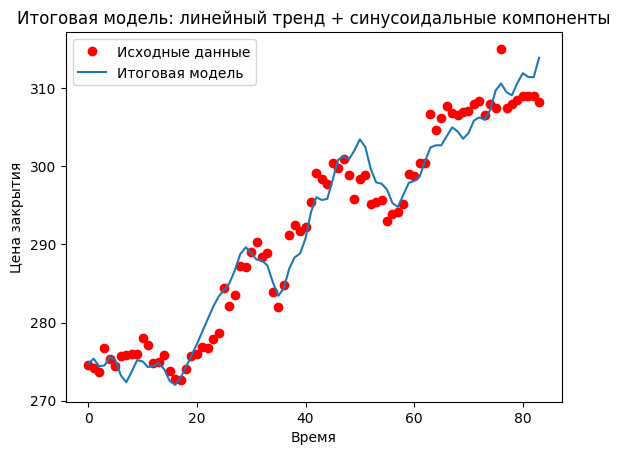

In [15]:
# Линейная часть
linear_trend = model_params[0] + model_params[1] * time

# Инициализация итоговой модели
final_model = linear_trend.copy()

# Добавление синусоидальных компонент
for i, freq in enumerate(freq_params):
    cos_component = np.cos(2 * np.pi * freq * time)
    sin_component = np.sin(2 * np.pi * freq * time)

    # Учет параметров из fourier_params
    if f'Sin{i+1}' in fourier_params:
        final_model += fourier_params[f'Sin{i+1}'][0] * sin_component
    if f'Cos{i+1}' in fourier_params:
        final_model += fourier_params[f'Cos{i+1}'][0] * cos_component
    if f'Sin{i+1} & Cos{i+1}' in fourier_params:
        sin_coeff, cos_coeff = fourier_params[f'Sin{i+1} & Cos{i+1}']
        final_model += sin_coeff * sin_component + cos_coeff * cos_component

# Построение графика итоговой модели
plt.plot(time, data["<CLOSE>"].to_numpy(), 'ro', label='Исходные данные')
plt.plot(time, final_model, label='Итоговая модель')
plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Итоговая модель: линейный тренд + синусоидальные компоненты")
plt.legend()
plt.show()

In [16]:
# Создание матрицы признаков
X_final = sm.add_constant(time)  # Константа и линейный тренд

# Добавление синусоидальных компонент
for i, freq in enumerate(freq_params):
    cos_component = np.cos(2 * np.pi * freq * time)
    sin_component = np.sin(2 * np.pi * freq * time)

    # Учет параметров из fourier_params
    if f'Sin{i+1}' in fourier_params:
        X_final = np.column_stack((X_final, sin_component))
    if f'Cos{i+1}' in fourier_params:
        X_final = np.column_stack((X_final, cos_component))
    if f'Sin{i+1} & Cos{i+1}' in fourier_params:
        X_final = np.column_stack((X_final, sin_component, cos_component))

# Подгонка модели
final_ols_model = sm.OLS(y, X_final).fit()

# Вывод summary
print(final_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                <CLOSE>   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     342.0
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           7.00e-58
Time:                        15:49:54   Log-Likelihood:                -153.83
No. Observations:                  84   AIC:                             337.7
Df Residuals:                      69   BIC:                             374.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        270.8098      0.662    409.306      0.0

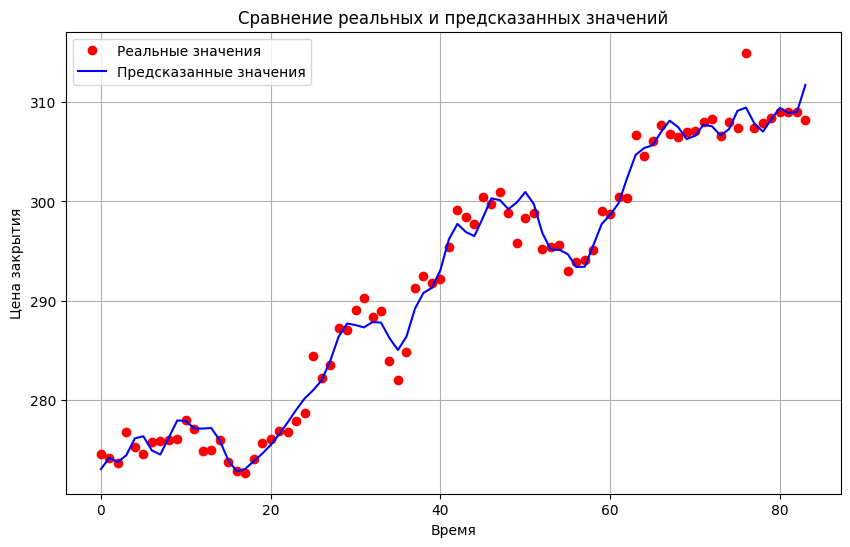

In [17]:
# Получение предсказанных значений
predicted_values = final_ols_model.predict(X_final)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(time, y, 'ro', label='Реальные значения')  # Реальные значения
plt.plot(time, predicted_values, 'b-', label='Предсказанные значения')  # Предсказанные значения
plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid()
plt.show()

In [18]:
from statsmodels.stats.stattools import durbin_watson

# Вычисление статистики Дарбина-Уотсона
dw_test = durbin_watson(final_ols_model.resid)
print(f"Статистика Дарбина-Уотсона: {dw_test}")

Статистика Дарбина-Уотсона: 1.76616704284849


In [19]:
#Здесь значение близкое к 2 указывает на отсутствие автокорреляции, то есть остатки можно считать независимыми

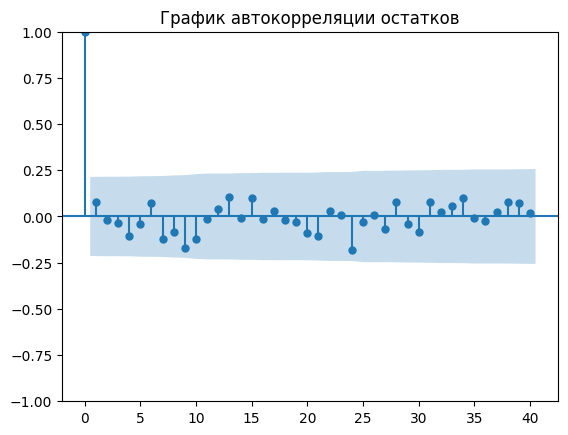

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

# График автокорреляции остатков
plot_acf(final_ols_model.resid, lags=40)
plt.title("График автокорреляции остатков")
plt.show()

In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Тест Бреуша-Пагана
bp_test = het_breuschpagan(final_ols_model.resid, final_ols_model.model.exog)
print(f"Тест Бреуша-Пагана: LM-статистика = {bp_test[0]}, p-value = {bp_test[1]}")

Тест Бреуша-Пагана: LM-статистика = 13.664585725089866, p-value = 0.47498686008856805


In [22]:
#Принимаем нулевую гипотезу о гомоскедастичности (то есть дисперсия является постоянной)

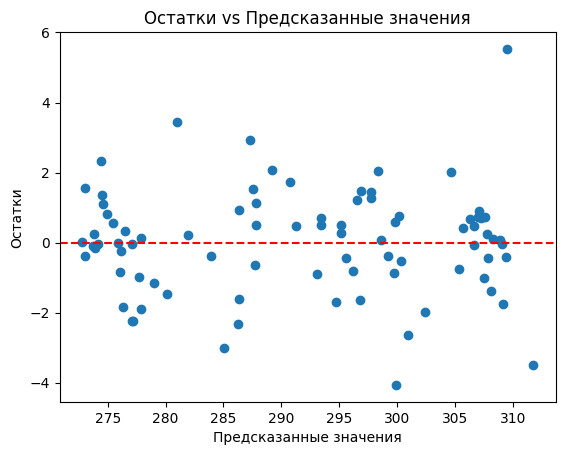

In [23]:
# График остатков vs предсказанные значения
plt.scatter(final_ols_model.fittedvalues, final_ols_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("Остатки vs Предсказанные значения")
plt.show()

In [24]:
from scipy.stats import shapiro

# Тест Шапиро-Уилка
shapiro_test = shapiro(final_ols_model.resid)
print(f"Тест Шапиро-Уилка: W-статистика = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

Тест Шапиро-Уилка: W-статистика = 0.9747980996084719, p-value = 0.09813935556420914


In [25]:
#Данные распределены нормально (P-value > 0.05)

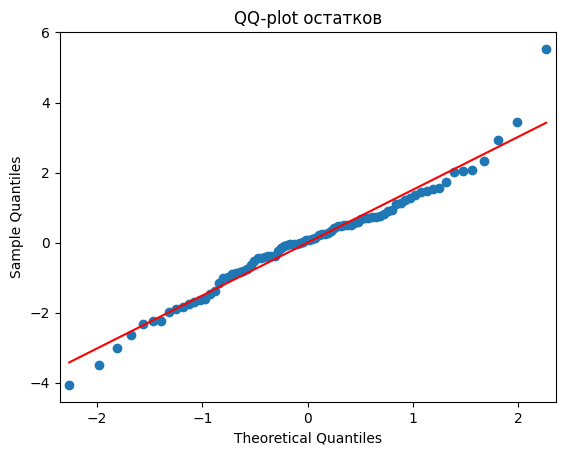

In [26]:
import statsmodels.api as sm

# QQ-plot остатков
sm.qqplot(final_ols_model.resid, line='s')
plt.title("QQ-plot остатков")
plt.show()

In [27]:
#Поскольку остатки независимы, гомоскедастичны и нормально распределены, а так же R^2 = 0.986, то есть использование модели можно считать более чем обоснованным.

In [28]:
# Шаг 1: Создание данных для прогноза
future_time = np.arange(1, len(time) + 4)  # Временные метки для 4 шагов вперед
X_future = sm.add_constant(future_time)  # Константа и линейный тренд

# Добавление синусоидальных компонент для будущих временных меток
for i, freq in enumerate(freq_params):
    cos_component = np.cos(2 * np.pi * freq * future_time)
    sin_component = np.sin(2 * np.pi * freq * future_time)

    if f'Sin{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, sin_component))
    if f'Cos{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, cos_component))
    if f'Sin{i+1} & Cos{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, sin_component, cos_component))

# Шаг 2: Прогнозирование
predictions = final_ols_model.get_prediction(X_future)
predicted_values = predictions.predicted_mean  # Точечный прогноз
confidence_intervals = final_ols_model.conf_int()  # Доверительные интервалы

In [34]:
coefficients = final_ols_model.params  # Точечные оценки коэффициентов

# Шаг 2: Вывод результатов
results_df = pd.DataFrame({
    'Коэффициент': coefficients,
    'Нижняя граница': confidence_intervals[0],
    'Верхняя граница': confidence_intervals[1]
})
print("Коэффициенты и их доверительные интервалы:")
print(results_df)

Коэффициенты и их доверительные интервалы:
       Коэффициент  Нижняя граница  Верхняя граница
const   270.809765      269.489845       272.129685
x1        0.501606        0.471026         0.532187
x2        2.772852        2.221188         3.324516
x3        2.180760        1.666849         2.694670
x4        0.924118        0.343745         1.504491
x5       -1.078711       -1.592621        -0.564800
x6       -1.204929       -1.742787        -0.667072
x7       -1.058103       -2.023050        -0.093156
x8       -0.750261       -1.264172        -0.236350
x9        0.640962        0.115420         1.166504
x10       0.755714        0.235323         1.276105
x11       0.708026        0.194115         1.221937
x12       0.673529        0.159619         1.187440
x13       0.479295       -0.034935         0.993524
x14       0.469385       -0.044526         0.983296


In [30]:
actual_values = y

In [31]:
data2topred = pd.read_csv('SBER_240424_240428.csv', delimiter=',')

realval4 = data2topred["<CLOSE>"].to_numpy()
data2topred.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>
0,SBER,D,240424,0,307.94
1,SBER,D,240425,0,308.41
2,SBER,D,240426,0,309.00
3,SBER,D,240427,0,308.98
4,SBER,D,240429,0,308.97


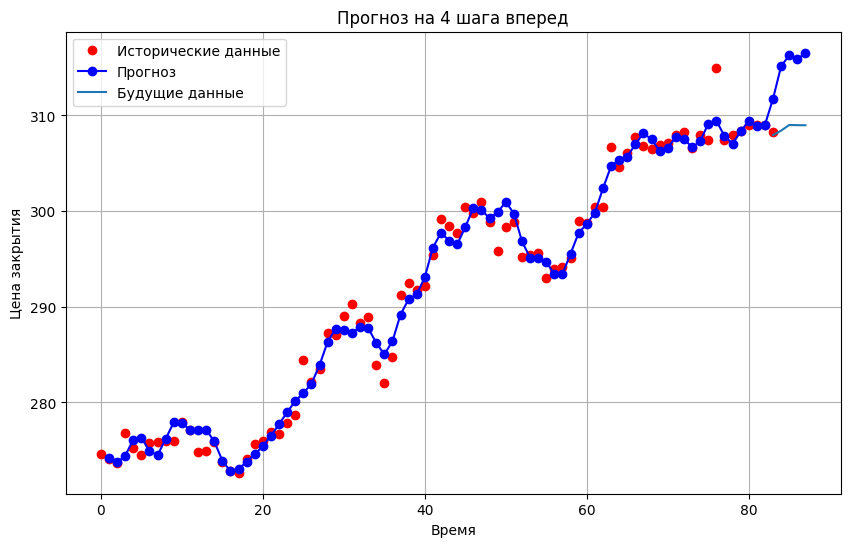

In [32]:
# Шаг 4: Визуализация
plt.figure(figsize=(10, 6))
plt.plot(time, y.to_numpy(), 'ro', label='Исторические данные')  # Исторические данные
plt.plot(future_time, predicted_values, 'bo-', label='Прогноз')  # Прогноз
plt.plot(future_time[-5:], realval4, label = 'Будущие данные')


plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Прогноз на 4 шага вперед")
plt.legend()
plt.grid()
plt.show()

In [33]:
#Здесь не получилось достоврено предсказать (тренд потерял свою силу)

In [36]:
data.head(10)

,<CLOSE>
0,274.56
1,274.12
2,273.62
3,276.76
4,275.28
5,274.49
6,275.71
7,275.84
8,275.96
9,276.01


In [42]:
len(time)

84

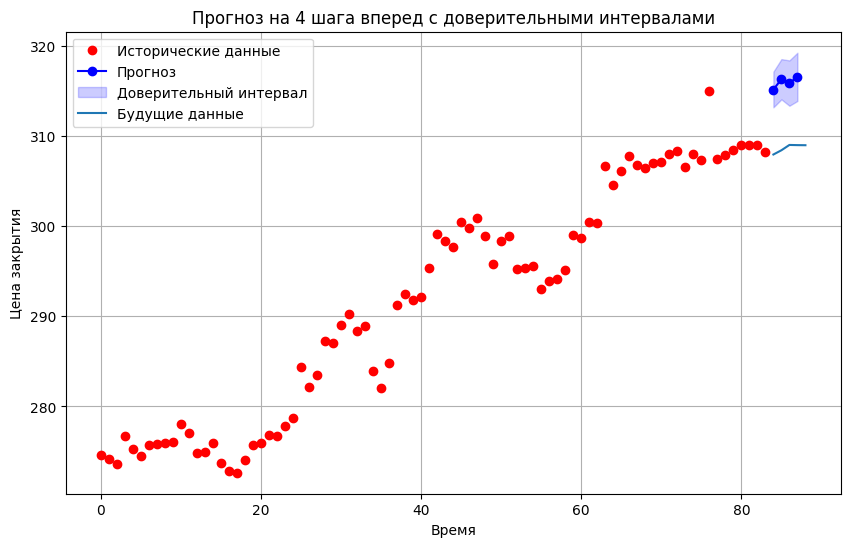

In [45]:
future_time = np.arange(len(time), len(time) + 4)  # Временные метки для 4 шагов вперед
X_future = sm.add_constant(future_time)  # Константа и линейный тренд

# Добавление синусоидальных компонент для будущих временных меток
for i, freq in enumerate(freq_params):
    cos_component = np.cos(2 * np.pi * freq * future_time)
    sin_component = np.sin(2 * np.pi * freq * future_time)

    if f'Sin{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, sin_component))
    if f'Cos{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, cos_component))
    if f'Sin{i+1} & Cos{i+1}' in fourier_params:
        X_future = np.column_stack((X_future, sin_component, cos_component))

# Шаг 2: Прогнозирование
predictions = final_ols_model.get_prediction(X_future)
predicted_values = predictions.predicted_mean  # Точечный прогноз
confidence_intervals = predictions.conf_int()  # Доверительные интервалы

# Шаг 3: Визуализация
plt.figure(figsize=(10, 6))
plt.plot(time, y, 'ro', label='Исторические данные')  # Исторические данные
plt.plot(future_time, predicted_values, 'bo-', label='Прогноз')  # Прогноз
plt.fill_between(future_time, confidence_intervals[:, 0], confidence_intervals[:, 1], color='blue', alpha=0.2, label='Доверительный интервал')  # Доверительный интервал
plt.plot([84,85,86,87,88], realval4, label = 'Будущие данные')

plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Прогноз на 4 шага вперед с доверительными интервалами")
plt.legend()
plt.grid()
plt.show()